In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use("seaborn-darkgrid")

<ipython-input-1-d92b30bbeee9>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-darkgrid")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from tqdm import tqdm

In [4]:
files=os.listdir("/content/drive/MyDrive/db_photos")
files

['Aleja',
 'Dayana',
 'AlejaS',
 'fabian',
 'profe',
 'jorge',
 'NoIdentificado',
 'jeronimo']

In [5]:
image_array = []
label_array = []
path = "/content/drive/MyDrive/db_photos/"

# Diccionario para almacenar la asignación de subcarpetas a índices
subfolder_indices = {}

# loop through each sub-folder in train
for i in range(len(files)):
    # Guardar el nombre de la subcarpeta con su índice
    subfolder_indices[files[i]] = i

    # files in sub-folder
    file_sub = os.listdir(path + files[i])

    for k in tqdm(range(len(file_sub))):
        try:
            img = cv2.imread(path + files[i] + "/" + file_sub[k])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (96, 96))
            image_array.append(img)
            label_array.append(i)
        except:
            pass

# Mostrar las asignaciones de subcarpetas a índices
for subfolder, index in subfolder_indices.items():
    print(f"Subcarpeta: {subfolder}, Índice: {index}")


100%|██████████| 66/66 [00:22<00:00,  2.95it/s]

Subcarpeta: Aleja, Índice: 0
Subcarpeta: Dayana, Índice: 1
Subcarpeta: AlejaS, Índice: 2
Subcarpeta: fabian, Índice: 3
Subcarpeta: profe, Índice: 4
Subcarpeta: jorge, Índice: 5
Subcarpeta: NoIdentificado, Índice: 6
Subcarpeta: jeronimo, Índice: 7


In [6]:
import gc
gc.collect()

43

In [7]:
image_array=np.array(image_array)/255.0
label_array=np.array(label_array)

In [8]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(image_array,label_array,test_size=0.20, random_state=0)

In [9]:
from keras import layers,callbacks,utils,applications,optimizers
from keras.models import Sequential,Model,load_model

In [10]:
len(files) #8 personas

8

In [11]:
model=Sequential()
# I will use MobileNetV2 as an pretrained model
pretrained_model=tf.keras.applications.EfficientNetB0(input_shape=(96,96,3),include_top=False,
                                         weights="imagenet")
model.add(pretrained_model)
model.add(layers.GlobalAveragePooling2D())
# add dropout to increase accuracy by not overfitting
model.add(layers.Dropout(0.20))
# add dense layer as final output
model.add(layers.Dense(1))
model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 3, 3, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4050852 (15.45 MB)
Trainable params: 4008829 (15.29 MB)
Non-trainable params: 42023 (164.16 KB)
_____________

In [12]:
model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mae"])

In [13]:
# creating a chechpoint to save model at best accuarcy

ckp_path="trained_model/model"
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,
                                                   monitor="val_mae",
                                                   mode="auto",
                                                   save_best_only=True,
                                                   save_weights_only=True)

In [14]:
# create a lr reducer which decrease learning rate when accuarcy does not increase
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(factor=0.9,monitor="val_mae",
                                             mode="auto",cooldown=0,
                                             patience=5,verbose=1,min_lr=1e-6)
# patience : wait till 5 epoch
# verbose : show accuracy every 1 epoch
# min_lr=minimum learning rate
#

In [15]:
EPOCHS=200
BATCH_SIZE=32

history=model.fit(X_train,
                 Y_train,
                 validation_data=(X_test,Y_test),
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[model_checkpoint,reduce_lr]
                 )

Epoch 1/200
19/19 [==============================] - 47s 338ms/step - loss: 6.4642 - mae: 1.9474 - val_loss: 28.6472 - val_mae: 4.8746 - lr: 0.0010
Epoch 2/200
19/19 [==============================] - 2s 107ms/step - loss: 2.2472 - mae: 1.1548 - val_loss: 18.8453 - val_mae: 3.7375 - lr: 0.0010
Epoch 3/200
19/19 [==============================] - 2s 114ms/step - loss: 1.8614 - mae: 1.0318 - val_loss: 15.2503 - val_mae: 3.2549 - lr: 0.0010
Epoch 4/200
19/19 [==============================] - 3s 142ms/step - loss: 1.3160 - mae: 0.8637 - val_loss: 11.8138 - val_mae: 2.8276 - lr: 0.0010
Epoch 5/200
19/19 [==============================] - 1s 74ms/step - loss: 0.8985 - mae: 0.6993 - val_loss: 12.3737 - val_mae: 2.9034 - lr: 0.0010
Epoch 6/200
19/19 [==============================] - 2s 104ms/step - loss: 0.6991 - mae: 0.6357 - val_loss: 11.3177 - val_mae: 2.7594 - lr: 0.0010
Epoch 7/200
19/19 [==============================] - 2s 105ms/step - loss: 0.6744 - mae: 0.6166 - val_loss: 9.5516 - v

In [16]:
model.load_weights(ckp_path)

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [18]:
prediction_val=model.predict(X_test,batch_size=BATCH_SIZE)

5/5 [==============================] - 2s 21ms/step


In [19]:
prediction_val
np.savetxt('prediction_val.csv', np.round(prediction_val).astype(int), delimiter=',', fmt='%d')

In [20]:
Y_test
np.savetxt('targets.csv', Y_test, delimiter=',', fmt='%d')

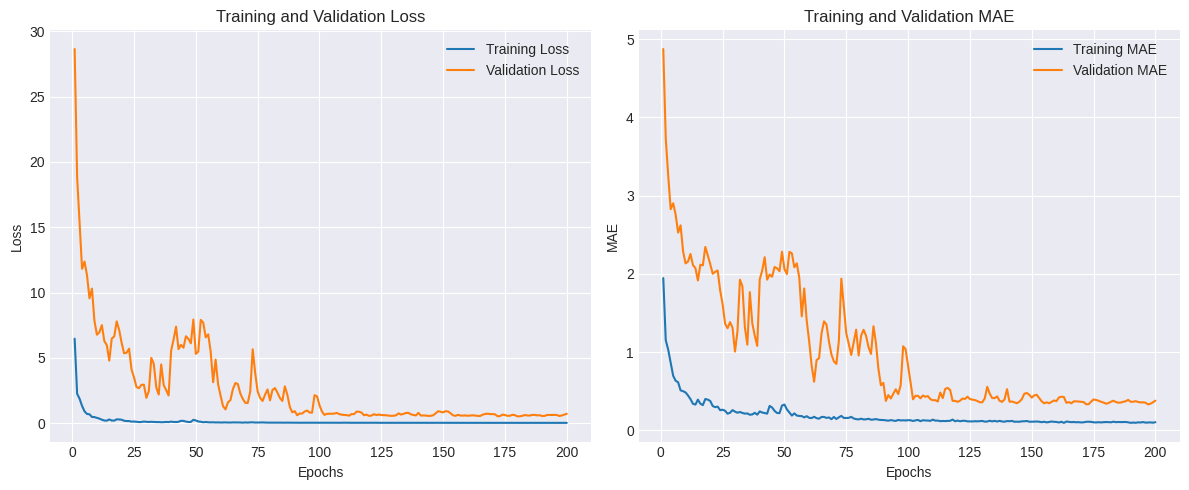

In [21]:
import matplotlib.pyplot as plt

# Obtener los valores de las métricas
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = list(range(1, len(loss) + 1))

# Encontrar el índice del valor máximo de val_loss y val_mae
max_val_loss_index = val_loss.index(max(val_loss))
max_val_mae_index = val_mae.index(max(val_mae))

'''val_loss.pop(max_val_loss_index)
loss.pop(max_val_loss_index)
val_mae.pop(max_val_mae_index)
mae.pop(max_val_mae_index)
epochs.pop(max_val_mae_index)  # Asumiendo que val_loss y val_mae tienen el mismo índice de época'''

'''del val_loss[max_val_loss_index]
del loss[max_val_loss_index]
del val_mae[max_val_mae_index]
del mae[max_val_mae_index]
del epochs[max_val_loss_index]'''

# Crear las gráficas de pérdida
plt.figure(figsize=(12, 5))

# Pérdida de entrenamiento y validación
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# MAE de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')

plt.tight_layout()
plt.show()


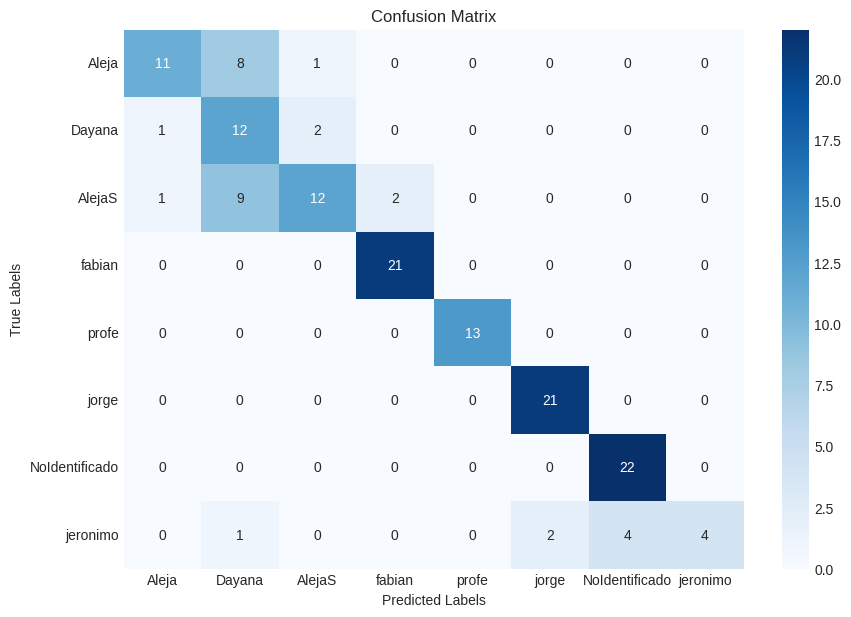

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(Y_test, np.round(prediction_val).astype(int))

labels = list(subfolder_indices.keys())

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()